In [1]:
" Simple Solar-Electric Powered Aircraft Model "
import pandas as pd
import numpy as np
from numpy import pi
from numpy import sin, tan, cos, arccos, deg2rad
import os
from gpkit import Model, Variable, SignomialsEnabled, Vectorize
import matplotlib.pyplot as plt

In [2]:
def summing_vars(models, varname):
    "returns a list of variables with shared varname in model list"
    modelnames = [m.__class__.__name__ for m in models]
    vkeys = np.hstack([list(m.varkeys[varname]) for m in models])
    vkeys = [v for v in vkeys if v.models[-1] in modelnames]
    vrs = [m[v] for m, v in zip(models, vkeys)]
    return vrs

def get_Eirr(latitude, day, N=50.0):
    """
    day is juilian day, measured from Jan 1st
    latitude is in degrees
    Returns:
    -------
    ESirr: Solar energy per unit area of from the sun Whr/m^2
    tday: time of daylight
    tnight: time of daylight
    p: 2d array [2, 50] Power per unit area [0] and time array [1]
    """
    assert isinstance(day, int)

    beta = 2*np.pi*(day-1)/365
    lat = deg2rad(latitude)
    delta = (0.006918 - 0.399912*cos(beta) + 0.070257*sin(beta) -
             0.006758*cos(2*beta) + 0.000907*sin(2*beta) -
             0.002697*cos(3*beta) + 0.00148*sin(3*beta))
    tstart = 12/np.pi*arccos(-tan(delta)*tan(lat))
    tend = -tstart
    t = np.linspace(tstart, tend, N)
    costhsun = sin(delta)*sin(lat) + cos(delta)*cos(lat)*cos(2*np.pi*t/24)

    r0 = 149.597e6 # avg distance from earth to sun km
    Reo = r0*(1 + 0.017*sin(2*np.pi*(day-93)/365))
    Psun = 63372630 # energy from sun surface W/m^2
    Rsun = 695842 # radius of the sun, km
    P0 = Psun*4*np.pi*Rsun**2/4/np.pi/Reo**2
    tau = np.exp(-0.175/costhsun)
    P = P0*costhsun# *tau
    E = np.trapz(P)*(abs(tend-tstart))/N
    tday = tstart*2
    tnight = 24-tstart*2
    plot = [P, t]
    return E, tday, tnight, plot

def plot_sens(model, sol, varnames):
    fig, ax = plt.subplots()
    pss = []
    ngs = []
    sens = {}
    for vname in varnames:
        sen = sol["sensitivities"]["constants"][vname]
        if hasattr(sen, "__len__"):
            vk = max(sen)
            sen = sol["sensitivities"]["constants"][vk]
        else:
            vk = model[vname]
        sens[vk] = sen

    labels = []
    for s in sorted(np.absolute(sens.values()), reverse=True):
        vn = [se for se in sens if abs(sens[se]) == s][0]
        labels.append(model[vn].descr["label"])
        if sens[vn] > 0:
            pss.append(sens[vn])
            ngs.append(0)
        else:
            ngs.append(abs(sens[vn]))
            pss.append(0)    
    
    ind = np.arange(0.5, len(varnames) + 0.5, 1)
    ax.bar(ind - 0.25, pss, 0.5, color="#4D606E")
    ax.bar(ind - 0.25, ngs, 0.5, color="#3FBAC2")
    ax.set_xlim([0.0, ind[-1]+0.5])
    ax.set_xticks(ind)
    ax.set_xticklabels(labels, rotation=-45, ha="left")
    ax.legend(["Positive", "Negative"])
    ax.set_ylabel("sensitivities")
    return fig, ax

In [3]:
class Wing(Model):
    "The thing that creates the lift"
    def setup(self, N=5, lam=0.5, spar="CapSpar", hollow=False):

        W = Variable("W", "lbf", "weight")
        mfac = Variable("m_{fac}", 1.2, "-", "wing weight margin factor")
        S = Variable("S", "ft^2", "surface area")
        AR = Variable("AR", "-", "aspect ratio")
        b = Variable("b", "ft", "wing span")
        tau = Variable("\\tau", 0.115, "-", "airfoil thickness ratio")
        CLmax = Variable("C_{L_{max}}", 1.39, "-", "maximum CL of JHO1")
        CM = Variable("C_M", 0.14, "-", "wing moment coefficient")
        mw = Variable("m_w", 2.0*np.pi/(1+2.0/23), "-",
                      "assumed span wise effectiveness")
        croot = Variable("c_{root}", "ft", "root chord")
        cmac = Variable("c_{MAC}", "ft", "mean aerodynamic chord")
        lamw = Variable("\\lambda", lam, "-", "wing taper ratio")
        cb, _ = c_bar(lam, N)
        with Vectorize(N):
            cbar = Variable("\\bar{c}", cb, "-",
                            "normalized chord at mid element")
        with Vectorize(N-1):
            cbave = Variable("\\bar{c}_{ave}", (cb[1:]+cb[:-1])/2, "-",
                             "normalized mid section chord")
            cave = Variable("c_{ave}", "ft", "mid section chord")

        constraints = [b**2 == S*AR,
                       lamw == lamw,
                       cbar == cbar,
                       cave == cbave*S/b,
                       croot == S/b*cb[0],
                       cmac == S/b]

        if spar == "CapSpar":
            self.spar = CapSpar(b, cave, tau, N)
        elif spar == "TubeSpar":
            self.spar = TubeSpar(b, cave, tau, N)
        self.wingskin = WingSkin(S, croot, b)
        self.components = [self.spar, self.wingskin]

        if not hollow:
            self.winginterior = WingInterior(cave, b, N)
            self.components.extend([self.winginterior])

        constraints.extend([W/mfac >= sum(c["W"] for c in self.components)])

        return self.components, constraints

    def flight_model(self, state):
        return WingAero(self, state)

    def loading(self, Wcent, Wwing=None, V=None, CL=None):
        return WingLoading(self, Wcent, Wwing, V, CL)

class WingLoading(Model):
    "wing loading cases"
    def setup(self, wing, Wcent, Wwing=None, V=None, CL=None):

        loading = [wing.wingskin.loading()]
        loading.append(wing.spar.loading(Wcent))
        if Wwing:
            loading.append(wing.spar.gustloading(Wcent, Wwing, V, CL))

        return loading

class WingAero(Model):
    "wing aerodynamic model with profile and induced drag"
    def setup(self, static, state):
        "wing drag model"
        Cd = Variable("C_d", "-", "wing drag coefficient")
        CL = Variable("C_L", "-", "lift coefficient")
        e = Variable("e", 0.9, "-", "span efficiency")
        Re = Variable("Re", "-", "Reynold's number")
        cdp = Variable("c_{dp}", "-", "wing profile drag coeff")

        constraints = [
            Cd >= cdp + CL**2/np.pi/static["AR"]/e,
            cdp**3.72 >= (0.0247*CL**2.49*Re**-1.11
                          + 2.03e-7*CL**12.7*Re**-0.338
                          + 6.35e10*CL**-0.243*Re**-3.43
                          + 6.49e-6*CL**-1.9*Re**-0.681),
            Re == state["\\rho"]*state["V"]*static["c_{MAC}"]/state["\\mu"],
            ]

        return constraints

class WingSkin(Model):
    "wing skin model"
    def setup(self, S, croot, b):

        rhocfrp = Variable("\\rho_{CFRP}", 1.6, "g/cm^3", "density of CFRP")
        W = Variable("W", "lbf", "wing skin weight")
        g = Variable("g", 9.81, "m/s^2", "gravitational acceleration")
        t = Variable("t", "in", "wing skin thickness")
        tmin = Variable("t_{min}", 0.012, "in",
                        "wing skin min gauge")
        Jtbar = Variable("\\bar{J/t}", 0.01114, "1/mm",
                         "torsional moment of inertia")

        constraints = [W >= rhocfrp*S*2*t*g,
                       t >= tmin,
                       b == b,
                       croot == croot]

        return constraints

    def loading(self):
        return WingSkinL(self)

class WingSkinL(Model):
    "wing skin loading model for torsional loads in skin"
    def setup(self, static):

        taucfrp = Variable("\\tau_{CFRP}", 570, "MPa", "torsional stress limit")
        Cmw = Variable("C_{m_w}", 0.121, "-", "negative wing moment coefficent")
        rhosl = Variable("\\rho_{sl}", 1.225, "kg/m^3",
                         "air density at sea level")
        Vne = Variable("V_{NE}", 45, "m/s", "never exceed vehicle speed")

        constraints = [
            taucfrp >= (1/static["\\bar{J/t}"]/(static["c_{root}"])**2
                        / static["t"]*Cmw*static["S"]*rhosl*Vne**2)]

        return constraints

class TubeSpar(Model):
    " tube spar model "
    def setup(self, b, cave, tau, N=5):

        self.N = N
        rho_cfrp = Variable("\\rho_{CFRP}", 1.6, "g/cm^3", "density of CFRP")
        E = Variable("E", 2e7, "psi", "Youngs modulus of CF")

        with Vectorize(self.N-1):
            d = Variable("d", "in", "spar diameter")
            I = Variable("I", "m^4", "spar x moment of inertia")
            Sy = Variable("S_y", "m**3", "section modulous")
            A = Variable("A", "in**2", "spar cross sectional area")
            dm = Variable("dm", "kg", "segment spar mass")

        W = Variable("W", "lbf", "tube spar weight")
        g = Variable("g", 9.81, "m/s**2", "gravitational constant")

        constraints = [
            dm >= rho_cfrp*A*b/(N-1),
            W >= 2*dm.sum()*g,
            cave*tau >= d,
            4*I**2/A**2/(d/2)**2 + A/pi <= (d/2)**2,
            Sy*(d/2) <= I,
            E == E
            ]

        return constraints

    def loading(self, Wcent):
        return ChordSparL(self, Wcent)

def c_bar(lam, N):
    "returns wing chord lengths for constant taper wing"
    eta = np.linspace(0, 1, N)
    c = 2/(1+lam)*(1+(lam-1)*eta)
    return c, eta

class ChordSparL(Model):
    "spar loading model"
    def setup(self, static, Wcent):

        Nmax = Variable("N_{max}", 5, "-", "max loading")
        cbar, _ = c_bar(0.5, static.N)
        sigmacfrp = Variable("\\sigma_{CFRP}", 1700e6, "Pa", "CFRP max stress")
        kappa = Variable("\\kappa", 0.2, "-", "max tip deflection ratio")

        with Vectorize(static.N-1):
            Mr = Variable("M_r", "N*m", "wing section root moment")

        with Vectorize(static.N):
            qbar = Variable("\\bar{q}", cbar, "-", "normalized loading")

        beam = Beam(static.N, qbar)

        constraints = [
            # dimensionalize moment of inertia and young's modulus
            beam["\\bar{EI}"] <= (8*static["E"]*static["I"]/Nmax
                                  / Wcent/static["b"]**2),
            Mr == (beam["\\bar{M}"][:-1]*Wcent*Nmax*static["b"]/4),
            sigmacfrp >= Mr/static["S_y"],
            beam["\\bar{\\delta}"][-1] <= kappa,
            ]

        return beam, constraints

class CapSpar(Model):
    "cap spar model"
    def setup(self, b, cave, tau, N=5):
        self.N = N

        # phyiscal properties
        rhocfrp = Variable("\\rho_{CFRP}", 1.6, "g/cm^3", "density of CFRP")
        E = Variable("E", 2e7, "psi", "Youngs modulus of CFRP")

        with Vectorize(self.N-1):
            t = Variable("t", "in", "spar cap thickness")
            hin = Variable("h_{in}", "in", "inner spar height")
            w = Variable("w", "in", "spar width")
            I = Variable("I", "m^4", "spar x moment of inertia")
            Sy = Variable("S_y", "m**3", "section modulus")
            dm = Variable("dm", "kg", "segment spar mass")

        W = Variable("W", "lbf", "spar weight")
        w_lim = Variable("w_{lim}", 0.15, "-", "spar width to chord ratio")
        g = Variable("g", 9.81, "m/s^2", "gravitational acceleration")

        constraints = [I <= 2*w*t*(hin/2)**2,
                       dm >= rhocfrp*w*t*b/2/(self.N-1),
                       W >= 2*dm.sum()*g,
                       w <= w_lim*cave,
                       cave*tau >= hin + 2*t,
                       Sy*(hin + t) <= I,
                      ]

        return constraints

    def loading(self, Wcent):
        return ChordSparL(self, Wcent)

    def gustloading(self, Wcent, Wwing, V, CL):
        return GustL(self, Wcent, Wwing, V, CL)

class Beam(Model):
    "discretized beam bending model"
    def setup(self, N, qbar):

        with Vectorize(N-1):
            EIbar = Variable("\\bar{EI}", "-",
                             "normalized YM and moment of inertia")

        with Vectorize(N):
            Sbar = Variable("\\bar{S}", "-", "normalized shear")
            Mbar = Variable("\\bar{M}", "-", "normalized moment")
            th = Variable("\\theta", "-", "deflection slope")
            dbar = Variable("\\bar{\\delta}", "-", "normalized displacement")


        Sbartip = Variable("\\bar{S}_{tip}", 1e-10, "-", "Tip loading")
        Mbartip = Variable("\\bar{M}_{tip}", 1e-10, "-", "Tip moment")
        throot = Variable("\\theta_{root}", 1e-10, "-", "Base angle")
        dbarroot = Variable("\\bar{\\delta}_{root}", 1e-10, "-",
                            "Base deflection")
        dx = Variable("dx", "-", "normalized length of element")

        constraints = [
            Sbar[:-1] >= Sbar[1:] + 0.5*dx*(qbar[:-1] + qbar[1:]),
            Sbar[-1] >= Sbartip,
            Mbar[:-1] >= Mbar[1:] + 0.5*dx*(Sbar[:-1] + Sbar[1:]),
            Mbar[-1] >= Mbartip,
            th[0] >= throot,
            th[1:] >= th[:-1] + 0.5*dx*(Mbar[1:] + Mbar[:-1])/EIbar,
            dbar[0] >= dbarroot,
            dbar[1:] >= dbar[:-1] + 0.5*dx*(th[1:] + th[:-1]),
            1 == (N-1)*dx,
            ]

        return constraints

class GustL(Model):
    "spar loading model"
    def setup(self, static, Wcent, Wwing, V, CL):
    # def setup(self, static, Wcent, rho, V, S):

        Nmax = Variable("N_{max}", 2, "-", "max loading")
        cbar, eta = c_bar(0.5, static.N)
        sigmacfrp = Variable("\\sigma_{CFRP}", 1700e6, "Pa", "CFRP max stress")
        kappa = Variable("\\kappa", 0.2, "-", "max tip deflection ratio")

        with Vectorize(static.N-1):
            Mr = Variable("M_r", "N*m", "wing section root moment")

        vgust = Variable("V_{gust}", 10, "m/s", "gust velocity")

        with Vectorize(static.N):
            agust = Variable("\\alpha_{gust}", "-", "gust angle of attack")
            qbar = Variable("\\bar{q}", "-", "normalized loading")
            cosminus1 = Variable("1-cos(\\eta)",
                                 np.hstack([1e-10, 1-np.cos(eta[1:]*pi/2)]),
                                 "-", "1 minus cosine factor")

        beam = Beam(static.N, qbar)

        constraints = [
            # fit for arctan from 0 to 1, RMS = 0.044
            agust == 0.905329*(cosminus1*vgust/V)**0.961857,
            qbar >= cbar*(1 + 2*pi*agust/CL*(1+Wwing/Wcent)),
            # dimensionalize moment of inertia and young's modulus
            beam["\\bar{EI}"] <= (8*static["E"]*static["I"]/Nmax
                                  / Wcent/static["b"]**2),
            Mr == (beam["\\bar{M}"][:-1]*Wcent*Nmax*static["b"]/4),
            sigmacfrp >= Mr/static["S_y"],
            beam["\\bar{\\delta}"][-1] <= kappa,
            ]

        return beam, constraints

In [4]:
class Empennage(Model):
    "empennage model, consisting of vertical, horizontal and tailboom"
    def setup(self):
        mfac = Variable("m_{fac}", 1.0, "-", "Tail weight margin factor")
        W = Variable("W", "lbf", "empennage weight")

        self.horizontaltail = HorizontalTail()
        self.verticaltail = VerticalTail()
        self.tailboom = TailBoom()
        self.components = [self.horizontaltail, self.verticaltail,
                           self.tailboom]

        constraints = [
            W/mfac >= (self.horizontaltail["W"] + self.verticaltail["W"]
                       + self.tailboom["W"]),
            self.tailboom["l"] >= self.horizontaltail["l_h"],
            self.tailboom["l"] >= self.verticaltail["l_v"],
            ]

        return self.components, constraints

    def loading(self):
        return EmpennageLoading(self)

class EmpennageLoading(Model):
    "tail boom loading case"
    def setup(self, empennage):
        state = TailBoomState()

        loading = [empennage.tailboom.horizontalbending(
            empennage.horizontaltail, state)]
        loading.append(empennage.tailboom.verticalbending(
            empennage.verticaltail, state))
        loading.append(empennage.tailboom.verticaltorsion(
            empennage.verticaltail, state))

        return loading

class HorizontalTail(Model):
    "horizontal tail model"
    def setup(self, lam=0.8):
        Sh = Variable("S", "ft**2", "horizontal tail area")
        Vh = Variable("V_h", "-", "horizontal tail volume coefficient")
        ARh = Variable("AR_h", "-", "horizontal tail aspect ratio")
        Abar = Variable("\\bar{A}_{NACA0008}", 0.0548, "-",
                        "cross sectional area of NACA 0008")
        rhofoam = Variable("\\rho_{foam}", 1.5, "lbf/ft^3",
                           "Density of formular 250")
        rhoskin = Variable("\\rho_{skin}", 0.049, "g/cm**2",
                           "horizontal tail skin density")
        bh = Variable("b", "ft", "horizontal tail span")
        W = Variable("W", "lbf", "horizontal tail weight")
        Vh = Variable("V_h", "-", "horizontal tail volume coefficient")
        g = Variable("g", 9.81, "m/s^2", "Gravitational acceleration")
        lh = Variable("l_h", "ft", "horizontal tail moment arm")
        CLhmin = Variable("(C_{L_h})_{min}", 0.75, "-",
                          "max downlift coefficient")
        mh = Variable("m_h", "-", "horizontal tail span effectiveness")
        cth = Variable("c_{t_h}", "ft", "horizontal tail tip chord")
        crh = Variable("c_{r_h}", "ft", "horizontal tail root chord")
        lamh = Variable("\\lambda", lam, "-", "horizontal tail taper ratio")
        lamhfac = Variable("\\lambda_h/(\\lambda_h+1)", lam/(lam+1), "-",
                           "horizontal tail taper ratio factor")
        CLhtmax = Variable("C_{L_{max}}", "-", "maximum CL of horizontal tail")
        mfac = Variable("m_{fac}", 1.1, "-", "horizontal tail margin factor")
        tau = Variable("\\tau", 0.08, "-", "horizontal tail thickness ratio")

        constraints = [
            bh**2 == ARh*Sh,
            mh*(1+2/ARh) <= 2*np.pi,
            W/mfac >= g*rhoskin*Sh + rhofoam*Sh**2/bh*Abar,
            cth == 2*Sh/bh*lamhfac,
            crh == cth/lam,
            lamh == lamh
            ]

        return constraints

    def flight_model(self, state):
        return TailAero(self, state)

class TailAero(Model):
    "horizontal tail aero model"
    def setup(self, static, state):

        name = get_lowername(static.__class__.__name__)
        Re = Variable("Re", "-", "%s reynolds number" % name)
        Cd = Variable("C_d", "-", "%s drag coefficient" % name)

        constraints = [
            Re == (state["V"]*state["\\rho"]*static["S"]/static["b"]
                   / state["\\mu"]),
            Cd**70.5599 >= (7.42688e-90*(Re/1000)**-33.0637
                            * (static["\\tau"]*100)**18.0419
                            + 5.02826e-163*(Re/1000)**-18.7959
                            * (static["\\tau"]*100)**53.1879
                            + 4.22901e-77*(Re/1000)**-41.1704
                            * (static["\\tau"]*100)**28.4609)
            ]

        return constraints

def get_lowername(classname):
    start = [c for c in classname if c.isupper()]
    name = [classname]
    for t in start:
        name = name[-1].split(t)

    n = " ".join([t.lower()+n for n, t in zip(name, start)])
    return n

class VerticalTail(Model):
    "vertical tail model"
    def setup(self, lam=0.7):

        W = Variable("W", "lbf", "one vertical tail weight")
        Sv = Variable("S", "ft**2", "total vertical tail surface area")
        Vv = Variable("V_v", 0.05, "-", "vertical tail volume coefficient")
        ARv = Variable("AR_v", "-", "vertical tail aspect ratio")
        bv = Variable("b", "ft", "one vertical tail span")
        rhofoam = Variable("\\rho_{foam}", 1.5, "lbf/ft^3",
                           "Density of formular 250")
        rhoskin = Variable("\\rho_{skin}", 0.049, "g/cm**2",
                           "vertical tail skin density")
        Abar = Variable("\\bar{A}_{NACA0008}", 0.0548, "-",
                        "cross sectional area of NACA 0008")
        g = Variable("g", 9.81, "m/s^2", "Gravitational acceleration")
        lv = Variable("l_v", "ft", "horizontal tail moment arm")
        ctv = Variable("c_{t_v}", "ft", "vertical tail tip chord")
        crv = Variable("c_{r_v}", "ft", "vertical tail root chord")
        lamv = Variable("\\lambda", lam, "-", "vertical tail taper ratio")
        lamvfac = Variable("\\lambda_v/(\\lambda_v+1)", lam/(lam+1), "-",
                           "vertical tail taper ratio factor")
        CLvtmax = Variable("C_{L_{max}}", 1.1, "-",
                           "maximum CL of vertical tail")
        mfac = Variable("m_{fac}", 1.1, "-", "vertical tail margin factor")
        tau = Variable("\\tau", 0.08, "-", "vertical tail thickness ratio")

        constraints = [bv**2 == ARv*Sv,
                       W/mfac >= rhofoam*Sv**2/bv*Abar + g*rhoskin*Sv,
                       ctv == 2*Sv/bv*lamvfac,
                       crv == ctv/lam,
                       lamv == lamv
                      ]

        return constraints

    def flight_model(self, state):
        return TailAero(self, state)

class TailBoom(Model):
    "tail boom model"
    def setup(self):

        l = Variable("l", "ft", "tail boom length")
        E = Variable("E", 150e9, "N/m^2", "young's modulus carbon fiber")
        k = Variable("k", 0.8, "-", "tail boom inertia value")
        kfac = Variable("(1-k/2)", 1-k.value/2, "-", "(1-k/2)")
        I0 = Variable("I_0", "m^4", "tail boom moment of inertia")
        d0 = Variable("d_0", "in", "tail boom diameter")
        t0 = Variable("t_0", "mm", "tail boom thickness")
        tmin = Variable("t_{min}", 0.25, "mm", "minimum tail boom thickness")
        rhocfrp = Variable("\\rho_{CFRP}", 1.6, "g/cm^3", "density of CFRP")
        g = Variable("g", 9.81, "m/s^2", "Gravitational acceleration")
        W = Variable("W", "lbf", "tail boom weight")
        J = Variable("J", "m^4", "tail boom polar moment of inertia")
        S = Variable("S", "ft**2", "tail boom surface area")
        mfac = Variable("m_{fac}", 1.0, "-", "tail boom margin factor")

        constraints = [
            I0 <= np.pi*t0*d0**3/8.0,
            W/mfac >= np.pi*g*rhocfrp*d0*l*t0*kfac,
            t0 >= tmin,
            J <= np.pi/8.0*d0**3*t0,
            S == l*np.pi*d0,
            k == k,
            E == E
            ]

        return constraints

    def flight_model(self, state):
        return TailBoomAero(self, state)

    def horizontalbending(self, htail, state):
        return HorizontalBoomBending(self, htail, state)

    def verticalbending(self, vtail, state):
        return VerticalBoomBending(self, vtail, state)

    def verticaltorsion(self, vtail, state):
        return VerticalBoomTorsion(self, vtail, state)

class TailBoomAero(Model):
    "horizontal tail aero model"
    def setup(self, static, state):

        Cf = Variable("C_f", "-", "fuselage skin friction coefficient")
        Re = Variable("Re", "-", "fuselage reynolds number")

        constraints = [
            Re == (state["V"]*state["\\rho"]*static["l"]/state["\\mu"]),
            Cf >= 0.455/Re**0.3,
            ]

        return constraints

class TailBoomState(Model):
    "tail boom design state"
    def setup(self):

        rhosl = Variable("\\rho_{sl}", 1.225, "kg/m^3",
                         "air density at sea level")
        Vne = Variable("V_{NE}", 40, "m/s", "never exceed vehicle speed")

        constraints = [rhosl == rhosl,
                       Vne == Vne]

        return constraints

class VerticalBoomTorsion(Model):
    "tail boom torison case"
    def setup(self, tailboom, vtail, state):

        T = Variable("T", "N*m", "vertical tail moment")
        taucfrp = Variable("\\tau_{CFRP}", 210, "MPa", "torsional stress limit")

        constraints = [
            T >= (0.5*state["\\rho_{sl}"]*state["V_{NE}"]**2*vtail["S"]
                  * vtail["C_{L_{max}}"]*vtail["b"]),
            taucfrp >= T*tailboom["d_0"]/2/tailboom["J"]
            ]

        return constraints

class VerticalBoomBending(Model):
    "tail boom bending loading case"
    def setup(self, tailboom, vtail, state):

        F = Variable("F", "N", "vertical tail force")
        th = Variable("\\theta", "-", "tail boom deflection angle")
        thmax = Variable("\\theta_{max}", 0.1, "-",
                         "max tail boom deflection angle")

        constraints = [
            F >= (0.5*state["\\rho_{sl}"]*state["V_{NE}"]**2*vtail["S"]
                  * vtail["C_{L_{max}}"]),
            th >= (F*tailboom["l"]**2/tailboom["E"]/tailboom["I_0"]
                   * (1+tailboom["k"])/2),
            th <= thmax,
            ]

        return constraints

class HorizontalBoomBending(Model):
    "tail boom bending loading case"
    def setup(self, tailboom, htail, state):

        F = Variable("F", "N", "horizontal tail force")
        th = Variable("\\theta", "-", "tail boom deflection angle")
        thmax = Variable("\\theta_{max}", 0.1, "-",
                         "max tail boom deflection angle")

        constraints = [
            F >= (0.5*state["\\rho_{sl}"]*state["V_{NE}"]**2*htail["S"]
                  * htail["C_{L_{max}}"]),
            th >= (F*tailboom["l"]**2/tailboom["E"]/tailboom["I_0"]
                   * (1+tailboom["k"])/2),
            th <= thmax,
            ]

        return constraints


In [5]:
data = {}
colnames = ["latitude" ,"c1", "e11", "e12", "c2", "e21", "e22", "c3", "e31", "e32", "c4", "e41", "e42", "alpha"]
data[20] = [20,9.77E-15,-8.446787541,53.06044647,52592.69084,9.976948092,6.264587751,1972.760705,7.659343514,39.25237507,3.90E-14,-7.263130773,10.64479149,5.52656349 ]
data[21] = [21,1.01E-13,-7.87805801,47.89727856,6.66E-13,-6.624575493,9.184557148,80902.24024,9.61437834,5.476855329,1364.466554,7.040001528,35.84319863,5.028944545 ]
data[22] = [22,111738.592,9.645926509,5.293842645,1.53E-13,-7.752127605,47.61001428,7.58E-13,-6.639203315,8.901606773,2032.71004,7.113101282,35.00366251,5.06352575 ]
data[23] = [23,2683.011093,7.113752774,34.02287441,1.07E-12,-6.611998514,8.672697189,134545.9247,9.59592789,5.08607143,4.20E-13,-7.45671626,48.58338398,5.076977057 ]
data[24] = [24,4805.511214,7.400750496,33.58382242,6.80E-13,-7.25039683,48.34000674,194596.448,9.812660238,5.083249416,4.84E-13,-6.865519594,8.905097027,5.314761277 ]
data[25] = [25,2.14E-12,-6.856286212,48.04187477,6282.860629,7.498171065,33.34144918,202305.7958,9.796573522,5.119690499,3.10E-13,-7.058140292,9.167082504,5.476661303 ]
data[26] = [26,7481.48421,7.513364932,34.68408984,294771.595,9.903598865,5.260347795,3.13E-13,-7.140050359,9.515895962,7.03E-12,-6.513627005,51.40110113,5.586380851 ]
data[27] = [27,362322.0847,10.03416399,5.435643787,7.09E-12,-6.542699494,51.06951728,1.29E-13,-7.442395106,9.714099741,8933.390523,7.571655632,36.29722601,5.81829612 ]
data[28] = [28,7.90E-14,-7.648487418,9.682368915,8886.45653,7.504225559,36.92381692,327547.585,9.954750685,5.583177519,6.85E-12,-6.635853492,49.30542896,5.958649338 ]
data[29] = [29,6.97E-14,-7.787045952,9.851219442,230293.5245,9.710110003,5.7194723,7673.165577,7.343650753,36.36184346,1.15E-11,-6.584090226,50.32237394,6.020170803 ]
data[30] = [30,4.20E-14,-8.046296572,10.2154371,128967.3205,9.38455178,5.996950413,5799.091011,7.145606836,36.41744923,1.44E-11,-6.623227736,52.24532,6.120903966 ]
data[31] = [31,2.17E-12,-7.20279658,57.59144623,9096.978906,7.562769087,40.54752405,1.22E-15,-9.093691267,11.76301432,125535.3829,9.68217375,7.213696707,6.894038184 ]
data[32] = [32,62127.15872,9.302094059,7.895581062,3.54E-12,-7.115827099,58.06309818,5.23E-16,-9.453380274,12.23544305,5996.587782,7.32344031,42.47150045,7.068126323 ]
data[33] = [33,1.86E-16,-9.864333,12.77223597,28076.55533,8.905155792,8.676829404,3979.253546,7.125691888,44.52671874,8.01E-12,-6.8912912,58.6547333,7.280021216 ]
data[34] = [34,9953.648746,8.4278531,9.538925976,4.70E-17,-10.37784163,13.52233405,2663.281642,6.965684497,46.6694584,1.19E-11,-6.793174223,60.97230107,7.551215622 ]
data[35] = [35,2918.053744,7.586821057,9.369942633,1.58E-10,-6.074328582,60.42101294,4.05E-16,-9.879332497,13.20435722,1048.391042,6.329695572,46.23129219,7.213372789 ]
data[36] = [36,455.5245199,5.770339626,44.99646596,3.40E-15,-9.350423333,12.80601534,833.5427427,6.791318933,8.979061801,1.23E-09,-5.518990729,58.76742502,6.920814528 ]
data[37] = [37,5.15E-14,-8.630307745,12.08762391,225.4279194,5.937719063,8.341462605,8.45E-09,-5.033723255,57.48227002,196.2466027,5.191445004,43.24063667,6.522972741 ]
data[38] = [38,84.81306614,4.632239954,41.61020449,4.69E-08,-4.609037155,55.30831915,67.84071867,5.132581927,7.677756081,8.55E-13,-7.865089009,11.23649491,6.101686717 ]
data[39] = [39,1.65E-11,-7.045560249,10.13633614,35.67515444,4.056361676,40.12526017,22.3672662,4.333448372,6.951091348,2.55E-07,-4.182107825,51.6776091,5.603612695 ]
data[40] = [40,16.74134191,3.565520317,38.40607363,2.62E-10,-6.278362252,9.049726818,1.32E-06,-3.745287056,47.9893571,8.727376826,3.627853683,6.248051026,5.113254529 ]
data[41] = [41,3.42E-09,-5.562169784,7.84302407,3.934348928,2.987378401,5.531037458,8.86E-06,-3.191086563,43.35939508,11.22177094,3.270390685,37.31540205,4.602539287 ]
data[42] = [42,2.057843516,2.417922085,4.799304699,4.04E-08,-4.869717202,6.627237859,10.26543175,3.164291742,35.82656284,6.03E-05,-2.613359125,39.18497794,4.073651272]
data[43] = [43,13.76976374,3.319445633,34.8938181,0.000427714,-2.005653801,36.67651545,1.273918114,1.933981288,4.089998204,4.21E-07,-4.215954158,5.580322861,3.545560965 ]
data[44] = [44,0.928897091,1.539893188,3.392499676,19.90551499,3.541130423,34.22385033,3.77E-06,-3.598701369,4.622304838,0.001914793,-1.535888044,34.28860451,3.025725827 ]
data[45] = [45,0.006095784,-1.158076004,32.55312905,2.75E-05,-3.035876321,3.828374275,0.783457308,1.243772288,2.761567191,27.54436823,3.752525293,34.18731701,2.547983789 ]
data[46] = [46,35.21855186,3.969032295,32.94422815,0.000196512,-2.47017963,3.017443863,0.758200861,1.008013798,2.132202205,0.017572129,-0.791212513,30.49188417,2.040565246 ]
data[47] = [47,0.001432781,-1.891678952,2.195109611,42.20854575,4.278104231,28.5397132,0.815933801,0.811312913,1.474096793,0.045989123,-0.429605438,28.92043043,1.490244429 ]
data[48] = [48,0.925838102,0.622471351,0.813656219,0.010821599,-1.289095918,1.3443699,0.105518143,-0.053777679,28.23331981,57.23843789,4.993089509,19.99326286,0.894851164 ]
data[49] = [49,56.48594759,5.665379721,11.33883359,0.12773884,0.183277877,27.43353509,0.949622441,0.455219635,0.348522332,0.053267497,-0.792742932,0.694818568,0.445408013 ]
data[50] = [50,0.868579431,0.354623137,0.148300147,24.07842645,5.472237271,7.615736073,0.08383683,0.217271534,27.10112773,0.139485325,-0.487389856,0.357656531,0.228705813 ]
data[51] = [51,4.880454655,4.985110767,5.718994202,0.657292346,0.237771423,0.019606852,0.029332119,0.213568819,27.70964916,0.344796804,-0.209567652,0.115955001,0.070285087 ]
data[52] = [52,0.008423447,0.166028408,27.95609673,0.833676579,4.314390519,4.863431277,0.614984902,-0.075429568,0.035463596,0.382990909,0.186047917,-0.016790916,0.021238985 ]
data[53] = [53,0.307294127,0.167934239,-0.026551372,0.334838258,3.597512157,4.104891891,0.686883473,-0.053799686,0.026388921,0.005635863,0.1199453,27.6852926,0.015463057 ]
data[54] = [54,0.004972343,0.091631521,27.45962661,0.223037148,3.086384577,3.424341968,0.539653234,-0.06700949,0.034640545,0.449072932,0.099162221,-0.024477118,0.014363973 ]
data[55] = [55,0.429312054,-0.080904621,0.054347612,0.005271277,0.077059008,27.72225495,0.206456855,2.768574175,3.253227327,0.553225896,0.072242692,-0.030516598,0.015843732 ]
data[56] = [56,0.1343704,2.615514698,3.275938379,0.62790054,0.043385444,-0.031864361,0.003484702,0.080412998,27.95866345,0.357665078,-0.071981172,0.064414949,0.010601285 ]
data[57] = [57,0.004205219,0.094331551,28.02762392,0.073350284,-0.168252688,0.206602063,0.905424736,0.012273821,-0.012989472,0.154839649,2.471359736,3.058861951,0.012839459 ]
data[58] = [58,0.007089839,0.106639433,28.77626994,0.036550549,-0.258276536,0.474140674,0.253357348,2.326196945,2.975032649,0.921020483,0.003730947,-0.012999853,0.022530392 ]
data[59] = [59,0.024238948,0.892324112,28.3603746,0.000155127,-1.210349139,16.07418282,0.944793634,-0.014707022,0.016087911,0.18784901,1.97871736,1.317013775,0.023259352]

In [6]:
DF = pd.DataFrame(data).transpose()
DF.columns = colnames

In [7]:
data = {}
colnames = ["latitude","Cc","Ce","Bc","Be"]
data[20] = [20.0,0.00289269160592,2.02031191821,15.3278198784,0.918628802645]
data[21] = [21.0,0.00291150268201,2.02075122074,15.2150696157,0.918627664894]
data[22] = [22.0,0.00293180491316,2.02119279367,15.1004236078,0.918626565448]
data[23] = [23.0,0.00295365873963,2.02163693789,14.9837792477,0.918625504266]
data[24] = [24.0,0.00297713071047,2.02208396132,14.8650281976,0.918624481413]
data[25] = [25.0,0.00300229408293,2.02253417974,14.7440558569,0.91862349707]
data[26] = [26.0,0.00302922950701,2.02298791776,14.6207407754,0.918622551532]
data[27] = [27.0,0.00305802580872,2.02344550986,14.494954003,0.918621645214]
data[28] = [28.0,0.00308878088863,2.02390730146,14.3665583687,0.918620778662]
data[29] = [29.0,0.00312160275514,2.02437365003,14.2354076782,0.91861995255]
data[30] = [30.0,0.00315661071636,2.02484492634,14.1013458186,0.918619167697]
data[31] = [31.0,0.00319393675932,2.02532151577,13.964205756,0.918618425071]
data[32] = [32.0,0.00323372715148,2.02580381969,13.8238084102,0.918617725798]
data[33] = [33.0,0.00327614430736,2.02629225702,13.6799613879,0.918617071177]
data[34] = [34.0,0.00332136897304,2.02678726583,13.5324575509,0.91861646269]
data[35] = [35.0,0.00336960279374,2.02728930514,13.3810733928,0.918615902017]
data[36] = [36.0,0.00342107134574,2.02779885688,13.2255671918,0.918615391054]
data[37] = [37.0,0.00347602773434,2.02831642794,13.065676901,0.918614931931]
data[38] = [38.0,0.0035347568866,2.02884255252,12.9011177286,0.918614527029]
data[39] = [39.0,0.00359758070208,2.02937779466,12.7315793507,0.918614179012]
data[40] = [40.0,0.00366486427122,2.02992275099,12.5567226867,0.918613890845]
data[41] = [41.0,0.00373702343209,2.03047805379,12.3761761492,0.91861366583]
data[42] = [42.0,0.0038145340189,2.03104437434,12.1895312613,0.91861350764]
data[43] = [43.0,0.00389794326738,2.03162242669,11.9963375042,0.918613420355]
data[44] = [44.0,0.00398788399685,2.03221297174,11.7960962244,0.91861340851]
data[45] = [45.0,0.00408509240273,2.03281682184,11.5882533788,0.918613477143]
data[46] = [46.0,0.00419043059654,2.03343484593,11.3721908364,0.918613631852]
data[47] = [47.0,0.0043049154639,2.03406797518,11.1472158644,0.918613878865]
data[48] = [48.0,0.00442975604178,2.03471720943,10.9125483102,0.918614225111]
data[49] = [49.0,0.0045664025505,2.03538362434,10.6673048255,0.918614678307]
data[50] = [50.0,0.00471661162558,2.03606837948,10.4104792406,0.918615247062]
data[51] = [51.0,0.0048825344673,2.03677272738,10.1409178617,0.918615940983]
data[52] = [52.0,0.005066838055,2.0374980239,9.85728796003,0.918616770818]
data[53] = [53.0,0.00527287512865,2.03824573994,9.55803697243,0.918617748602]
data[54] = [54.0,0.00550492790984,2.03901747472,9.24133876223,0.918618887842]
data[55] = [55.0,0.00576856653004,2.03981497107,8.90502143955,0.91862020372]
data[56] = [56.0,0.00607119181127,2.04064013291,8.54646818465,0.918621713346]
data[57] = [57.0,0.00642288578976,2.04149504538,8.16247730259,0.918623436042]
data[58] = [58.0,0.00683779946415,2.04238199805,7.74905841331,0.918625393683]
data[59] = [59.0,0.0073365299927,2.043303512,7.30112411119,0.918627611104]
DF2 = pd.DataFrame(data).transpose()
DF2.columns = colnames

In [8]:
# DF = pd.read_csv(path + "windaltfitdata.csv")
# DF2 = pd.read_csv(path + "solarirrdata.csv")

class Aircraft(Model):
    "vehicle"
    def setup(self):

        self.solarcells = SolarCells()
        self.wing = Wing(hollow=True)
        self.battery = Battery()
        self.empennage = Empennage()
        self.motor = Motor()

        self.components = [self.solarcells, self.wing, self.battery,
                           self.empennage, self.motor]

        Wpay = Variable("W_{pay}", 10, "lbf", "payload")
        Wtotal = Variable("W_{total}", "lbf", "aircraft weight")
        Wwing = Variable("W_{wing}", "lbf", "wing weight")
        Wcent = Variable("W_{cent}", "lbf", "center weight")

        self.empennage.substitutions["V_h"] = 0.45
        self.empennage.substitutions["V_v"] = 0.04
        self.empennage.substitutions["m_h"] = 5.514

        constraints = [
            Wtotal >= (Wpay + sum(summing_vars(self.components, "W"))),
            Wwing >= (sum(summing_vars([self.wing, self.battery,
                                        self.solarcells], "W"))),
            Wcent >= Wpay + sum(summing_vars([self.empennage, self.motor],
                                             "W")),
            self.solarcells["S"] <= self.wing["S"],
            self.wing["c_{MAC}"]**2*0.5*self.wing["\\tau"]*self.wing["b"] >= (
                self.battery["\\mathcal{V}"]),
            self.empennage.horizontaltail["V_h"] <= (
                self.empennage.horizontaltail["S"]
                * self.empennage.horizontaltail["l_h"]/self.wing["S"]**2
                * self.wing["b"]),
            self.empennage.verticaltail["V_v"] <= (
                self.empennage.verticaltail["S"]
                * self.empennage.verticaltail["l_v"]/self.wing["S"]
                / self.wing["b"]),
            self.empennage.horizontaltail["C_{L_{max}}"] == 1.5,
            self.wing["\\tau"]*self.wing["c_{root}"] >= self.empennage.tailboom["d_0"]
            ]

        return constraints, self.components

    def flight_model(self, state):
        return AircraftPerf(self, state)

    def loading(self, Wcent, Wwing, V, CL):
        return AircraftLoading(self, Wcent, Wwing, V, CL)

class Motor(Model):
    "the thing that provides power"
    def setup(self):

        W = Variable("W", "lbf", "motor weight")
        Pmax = Variable("P_{max}", "W", "max power")
        Bpm = Variable("B_{PM}", 4140.8, "W/kg", "power mass ratio")
        m = Variable("m", "kg", "motor mass")
        g = Variable("g", 9.81, "m/s**2", "gravitational constant")
        eta = Variable("\\eta", 1.0, "-", "motor efficiency")

        constraints = [Pmax == Bpm*m,
                       W >= m*g]

        return constraints

class AircraftLoading(Model):
    "aircraft loading cases"
    def setup(self, aircraft, Wcent, Wwing, V, CL):

        loading = [aircraft.wing.loading(Wcent, Wwing, V, CL)]
        loading.append(aircraft.empennage.loading())

        # tbstate = TailBoomState()
        # loading.append(TailBoomFlexibility(aircraft.empennage.horizontaltail,
        #                                    aircraft.empennage.tailboom,
        #                                    aircraft.wing, tbstate))

        return loading

class Battery(Model):
    "battery model"
    def setup(self):

        W = Variable("W", "lbf", "battery weight")
        eta_charge = Variable("\\eta_{charge}", 0.98, "-",
                              "Battery charging efficiency")
        eta_discharge = Variable("\\eta_{discharge}", 0.98, "-",
                                 "Battery discharging efficiency")
        E = Variable("E", "J", "total battery energy")
        g = Variable("g", 9.81, "m/s**2", "gravitational constant")
        hbatt = Variable("h_{batt}", 350, "W*hr/kg", "battery energy density")
        vbatt = Variable("(E/\\mathcal{V})", 800, "W*hr/l",
                         "volume battery energy density")
        Volbatt = Variable("\\mathcal{V}", "m**3", "battery volume")

        constraints = [W >= E/hbatt*g,
                       Volbatt >= E/vbatt,
                       eta_charge == eta_charge,
                       eta_discharge == eta_discharge]

        return constraints

class SolarCells(Model):
    "solar cell model"
    def setup(self):

        rhosolar = Variable("\\rho_{solar}", 0.27, "kg/m^2",
                            "solar cell area density")
        g = Variable("g", 9.81, "m/s**2", "gravitational constant")
        S = Variable("S", "ft**2", "solar cell area")
        W = Variable("W", "lbf", "solar cell weight")
        etasolar = Variable("\\eta", 0.22, "-", "Solar cell efficiency")

        constraints = [W >= rhosolar*S*g]

        return constraints

class AircraftPerf(Model):
    "aircraft performance"
    def setup(self, static, state):

        self.wing = static.wing.flight_model(state)
        self.htail = static.empennage.horizontaltail.flight_model(state)
        self.vtail = static.empennage.verticaltail.flight_model(state)
        self.tailboom = static.empennage.tailboom.flight_model(state)

        self.flight_models = [self.wing, self.htail, self.vtail,
                              self.tailboom]
        areadragmodel = [self.htail, self.vtail, self.tailboom]
        areadragcomps = [static.empennage.horizontaltail,
                         static.empennage.verticaltail,
                         static.empennage.tailboom]

        CD = Variable("C_D", "-", "aircraft drag coefficient")
        cda = Variable("CDA", "-", "non-wing drag coefficient")
        Pshaft = Variable("P_{shaft}", "hp", "shaft power")
        Pacc = Variable("P_{acc}", 0.0, "W", "Accessory power draw")
        Poper = Variable("P_{oper}", "W", "operating power")

        dvars = []
        for dc, dm in zip(areadragcomps, areadragmodel):
            if "C_f" in dm.varkeys:
                dvars.append(dm["C_f"]*dc["S"]/static.wing["S"])
            if "C_d" in dm.varkeys:
                dvars.append(dm["C_d"]*dc["S"]/static.wing["S"])

        constraints = [
            state["(E/S)_{irr}"] >= (
                state["(E/S)_{day}"] + static.battery["E"]
                / static.battery["\\eta_{charge}"]
                / static.solarcells["\\eta"]/static.solarcells["S"]),
            static.battery["E"]*static.battery["\\eta_{discharge}"] >= (
                Poper*state["t_{night}"]
                + state["(E/S)_C"]*static.solarcells["\\eta"]
                * static.solarcells["S"]),
            Poper >= Pacc + Pshaft/static.motor["\\eta"],
            Poper == (state["(P/S)_{min}"]*static.solarcells["S"]
                      * static.solarcells["\\eta"]),
            cda >= sum(dvars),
            CD >= cda + self.wing["C_d"],
            Poper <= static.motor["P_{max}"]
            ]

        return self.flight_models, constraints

class FlightState(Model):
    """
    environmental state of aircraft

    inputs
    ------
    latitude: earth latitude [deg]
    altitude: flight altitude [ft]
    percent: percentile wind speeds [%]
    day: day of the year [Jan 1st = 1]
    """
    def setup(self, latitude=45, day=355):

        df = DF[DF["latitude"] == latitude]
        df2 = DF2[DF2["latitude"] == latitude]
        esirr, td, tn, _ = get_Eirr(latitude, day)

        Vwind = Variable("V_{wind}", "m/s", "wind velocity")
        V = Variable("V", "m/s", "true airspeed")
        rho = Variable("\\rho", "kg/m**3", "air density")
        mu = Variable("\\mu", 1.42e-5, "N*s/m**2", "viscosity")
        ESirr = Variable("(E/S)_{irr}", esirr, "W*hr/m^2",
                         "total daytime solar energy")
        PSmin = Variable("(P/S)_{min}", "W/m^2",
                         "minimum necessary solar power")
        ESday = Variable("(E/S)_{day}", "W*hr/m^2",
                         "solar cells energy during daytime")
        ESc = Variable("(E/S)_C", "W*hr/m^2",
                       "energy for batteries during sunrise/set")
        ESvar = Variable("(E/S)_{var}", 1, "W*hr/m^2", "energy units variable")
        PSvar = Variable("(P/S)_{var}", 1, "W/m^2", "power units variable")
        tday = Variable("t_{day}", td, "hr", "Daylight span")
        tnight = Variable("t_{night}", tn, "hr", "Night span")
        pct = Variable("p_{wind}", 0.9, "-", "percentile wind speeds")
        Vwindref = Variable("V_{wind-ref}", 100.0, "m/s",
                            "reference wind speed")
        rhoref = Variable("\\rho_{ref}", 1.0, "kg/m**3",
                          "reference air density")
        mfac = Variable("m_{fac}", 1.0, "-", "wind speed margin factor")

        constraints = [
            V/mfac >= Vwind,
            (Vwind/Vwindref)**df["alpha"].iloc[0] >= (
                sum([df["c%d" % i]*(rho/rhoref)**df["e%d1" % i]
                     * pct**df["e%d2" % i] for i in range(1, 5)]).iloc[0]),
            ESday/ESvar == df2["Bc"].iloc[0]*(PSmin/PSvar)**df2["Be"].iloc[0],
            ESc/ESvar == df2["Cc"].iloc[0]*(PSmin/PSvar)**df2["Ce"].iloc[0]
            ]

        return constraints

def altitude(density):
    g = 9.80665 # m/s^2
    R = 287.04 # m^2/K/s^2
    T11 = 216.65 # K
    p11 = 22532 # Pa
    p = density*R*T11
    h = (11000 - R*T11/g*np.log(p/p11))/0.3048
    return h

class FlightSegment(Model):
    "flight segment"
    def setup(self, aircraft, etap=0.8, latitude=35, day=355):

        self.aircraft = aircraft
        self.fs = FlightState(latitude=latitude, day=day)
        self.aircraftPerf = self.aircraft.flight_model(self.fs)
        self.slf = SteadyLevelFlight(self.fs, self.aircraft,
                                     self.aircraftPerf, etap)

        self.submodels = [self.fs, self.aircraftPerf, self.slf]

        return self.aircraft, self.submodels

class SteadyLevelFlight(Model):
    "steady level flight model"
    def setup(self, state, aircraft, perf, etap):

        T = Variable("T", "N", "thrust")
        etaprop = Variable("\\eta_{prop}", etap, "-", "propeller efficiency")

        constraints = [
            aircraft["W_{total}"] <= (
                0.5*state["\\rho"]*state["V"]**2*perf["C_L"]
                * aircraft.wing["S"]),
            T >= (0.5*state["\\rho"]*state["V"]**2*perf["C_D"]
                  *aircraft.wing["S"]),
            perf["P_{shaft}"] >= T*state["V"]/etaprop]

        return constraints

class Mission(Model):
    "define mission for aircraft"
    def setup(self, latitude=35, day=355):

        self.solar = Aircraft()
        mission = []
        for l in range(20, latitude+1, 1):
            mission.append(FlightSegment(self.solar, latitude=l, day=day))
        loading = self.solar.loading(self.solar["W_{cent}"], self.solar["W_{wing}"], 
                                     mission[-1]["V"], mission[-1]["C_L"])
        for vk in loading.varkeys["N_{max}"]:
            if "ChordSparL" in vk.descr["models"]:
                loading.substitutions.update({vk: 5})
            if "GustL" in vk.descr["models"]:
                loading.substitutions.update({vk: 2})

        return self.solar, mission, loading
    
def varstr(varname):
    mn = [max(M[sv].descr["modelnums"]) for sv in sol("(E/S)_{irr}") if
          abs(sol["sensitivities"]["constants"][sv]) > 0.01][0]
    for vk in M.varkeys[varname]:
        if mn in vk.modelnums:
            mstr = varname + "_" + ", ".join([m + ".%d" % mn for m, mn in 
                                              zip(vk.models, vk.modelnums)])
    mstr = mstr.replace(".0", "")
    return mstr

def subbing(model, substitutions):
    " sub in dict "
    for s in substitutions:
        if hasattr(model.varkeys[s], "__len__"):
            for vk in model.varkeys[s]:
                model.substitutions.update({vk: substitutions[s]})
        else:
            model.substitutions.update({s: substitutions[s]})

In [9]:
M = Mission(latitude=30)
M.cost = M["W_{total}"]

In [10]:
# subbing(M, {"\\eta_{prop}": 0.85})
sol = M.solve("mosek")

Using solver 'mosek'
Solving for 375 variables.
Solving took 0.134 seconds.


In [11]:
print sol.table(showvars={"W_{total}", "b_Mission, Aircraft, Wing", 
                          "S_Mission, Aircraft, Wing", 
                          "h_{batt}", "\\eta_Mission, Aircraft, SolarCells"
                          "S_Mission, Aircraft, SolarCells", varstr("V"), 
                          varstr("C_L"), "AR_Mission, Aircraft, Wing", 
                          "\\eta_Mission, Aircraft, SolarCells",
                          varstr("\\eta_{prop}")})


Cost
----
 170.2 [lbf] 

Free Variables
--------------
          | Mission/Aircraft
W_{total} : 170.2                                                [lbf]   aircraft weight

          | Mission/Aircraft/Wing
       AR : 27.16                                                        aspect ratio
        S : 168.4                                                [ft**2] surface area
        b : 67.62                                                [ft]    wing span

          | Mission/FlightSegment.10/AircraftPerf.10/WingAero.10
      C_L : 1.124                                                        lift coefficient

          | Mission/FlightSegment.10/FlightState.10
        V : 26.23                                                [m/s]   true airspeed

Constants
---------
            | Mission/Aircraft/Battery
   h_{batt} : 350                                           [W*hr/kg] battery energy density

            | Mission/Aircraft/SolarCells
       \eta : 0.22                          

/Users/mjburton11/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


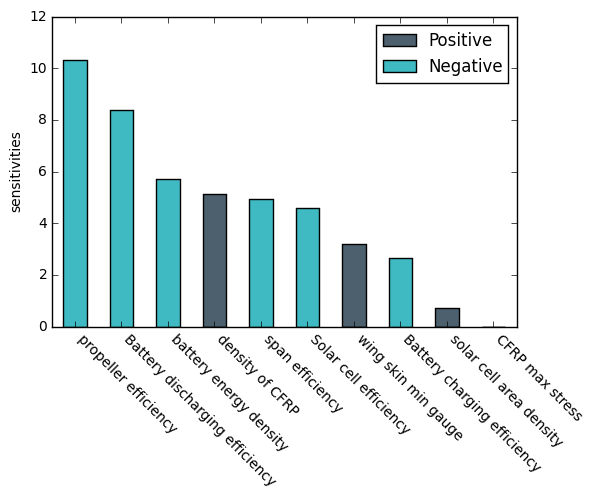

In [12]:
from print_sens import plot_sens
%matplotlib inline
varnsw = ["e", "t_{min}_Mission, Aircraft, Wing, WingSkin", "\\rho_{CFRP}", 
          "\\eta_{discharge}", "\\eta_{charge}", "h_{batt}", 
          "\\eta_Mission, Aircraft, SolarCells", "\\rho_{solar}", "\\eta_{prop}", 
          "\\sigma_{CFRP}"]
fig, ax = plot_sens(M, sol, varnsw)
fig.show()

In [13]:
fig.savefig("solarsensw.pdf")